# Evaporative Demand Drought Index (EDDI)

----

Benny Istanto, GOST/DEC Data Group/The World Bank

Python code for calculating the Evaporative Demand Drought Index (EDDI), a physically based drought monitoring and early warning guidance tool that measures drought dynamics based on atmospheric evaporative demand (E₀).

In [1]:
# Import the library
import os
import sys
import calendar
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


## Helper for dekad start-end

Calculates start and end dates for a specified dekad (10-day period) within a month. Handles three cases: dekad 1 (days 1-10), dekad 2 (days 11-20), and dekad 3 (day 21 to month end). Accounts for varying month lengths and returns datetime.date objects for both start and end dates.

In [2]:
# Dekad start/end helper
def get_dekad_dates(
        year, 
        month, 
        dekad
    ):
    """
    Given year, month, and dekad (1,2,3), return the actual
    start/end date for that dekad. (dekad1=1-10, dekad2=11-20, dekad3=21-end)
    """
    if dekad == 1:
        start = datetime.date(year, month, 1)
        end = datetime.date(year, month, 10)
    elif dekad == 2:
        start = datetime.date(year, month, 11)
        end = datetime.date(year, month, 20)
    elif dekad == 3:
        # Last day of month
        next_month = (month % 12) + 1
        next_month_year = year + (month // 12)
        last_day = (datetime.date(next_month_year, next_month, 1) - datetime.timedelta(days=1))
        start = datetime.date(year, month, 21)
        end = last_day
    else:
        raise ValueError("dekad must be 1, 2, or 3.")
    return start, end


## Helper for shift date backward

Shifts a given date backward by a specified number of months. Handles month/year transitions and adjusts for varying month lengths. Useful for calculating historical time windows in EDDI computation.

In [3]:
# Helper to shift a date backward by `n_months`
def shift_date_by_months(
        date_obj, 
        n_months
    ):
    """
    Shift a given date backward by n_months.
    For example, shift_date_by_months(2024-12-31, 3) -> ~2024-09-30 or 2024-09-31 (clamped).
    """
    month = date_obj.month - n_months
    year = date_obj.year
    day = date_obj.day
    while month <= 0:
        month += 12
        year -= 1
    # If day is out of range for the resulting month, clamp:
    last_day_new_month = (
        datetime.date(year, (month % 12) or 12, 1)
        + datetime.timedelta(days=31)
    ).replace(day=1) - datetime.timedelta(days=1)
    if day > last_day_new_month.day:
        day = last_day_new_month.day
    return datetime.date(year, month, day)



## Dekad rolling window

Determines the appropriate time window for EDDI calculation based on dekads. Takes year, month, dekad, and scale (in months) as input. Returns start and end dates that properly align with dekad boundaries, ensuring consistent temporal aggregation for EDDI calculation.

In [4]:
# Dekad rolling window
def get_dekad_based_month_window(
        year, 
        month, 
        dekad, 
        scale_in_months
    ):
    """
    Return a (start_date, end_date) that covers 'scale_in_months' of
    discrete, dekad-based months, ending on the actual final date for
    (year, month, dekad).

    Example:
    - If final is (Year=2024, Month=6, Dekad=3) => actual final day = 30 Jun 2024,
      and scale_in_months=6 => then start_date = 01 Jan 2024.
    - If final is (Year=2000, Month=2, Dekad=2) => actual final day=20 Feb 2000,
      scale_in_months=1 => then start_date=21 Jan 2000 => 20 Feb 2000 => 31 days total.

    We implement  custom logic:
      - "A 'month' is the portion from Dekad1 day=1 => last day (Dekad3), or
         from the relevant start day of that month to the relevant end day
         of the final month."
      - We step backward scale_in_months-1 whole months, then pick
        the appropriate "start dekad" so the total is exactly scale_in_months months.
    """

    # 1) Final date from (year, month, dekad)
    final_start, final_end = get_dekad_dates(year, month, dekad)
    # We'll treat final_end as the actual final day (like 20 Feb or 30 Jun).
    end_date = final_end

    # 2) Step backward (scale_in_months - 1) full months
    #    then choose a start dekad in that previous month
    # We'll define a function that steps back exactly 1 month
    def step_back_one_month(yr, mo):
        mo_new = mo - 1
        yr_new = yr
        if mo_new < 1:
            mo_new += 12
            yr_new -= 1
        return yr_new, mo_new

    # We start from the 'month, year' of the final date
    start_yr, start_mo = year, month

    for _ in range(scale_in_months - 1):
        start_yr, start_mo = step_back_one_month(start_yr, start_mo)

    # Now we must pick the "start dekad" to match our logic:
    # e.g. if final dekad=2 => that ends on day=20,
    #     then for a 1-month scale, we want start to be dekad=3 of previous month => day=21, etc.
    # But for longer scales, we want the 1st day (dekad=1 => day=1) if we are bridging multiple months.
    #
    # We'll define a simple rule:
    #   If scale_in_months=1 => the start dekad = (dekad+1) mod 3 in the previous month
    #   If scale_in_months>1 => the start date is the *first day* of that start_mo => dekad=1 => day=1
    #
    #   (We can refine if our logic differs, but let's assume we want to
    #    always have "complete months" from 1..end.)
    
    if scale_in_months == 1:
        # if final dekad=1 => final day=10 => start dekad=2 => day=11 => (previous month)
        # if final dekad=2 => final day=20 => start dekad=3 => day=21 => (previous month)
        # if final dekad=3 => final day=28..31 => start dekad=1 => day=1 => same month?
        #
        # But our example specifically said: final day=20 Feb => start=21 Jan => 1 month.
        # That means we must step back exactly 1 month from final date's month if final dekad=2.
        # Let's handle each final dekad:
        #   dekad=1 => final day=10 => 1 month => start day= sameMonth's dekad=2 => day=11 => 10 days total?? 
        #   That's only 10 days. Maybe we want 'the previous dekad'?? 
        #
        # Because our examples are:
        #   final dekad=2 feb => day=20 => start=21 jan => 1 month
        #   final dekad=3 june => day=30 => scale=6 => start=1 jan => 6 months
        # => It's best to handle them with our own custom logic table.

        if dekad == 1:
            # final day=10 => 1 month => start day= day=11 (which is dekad=2) of the *previous* month
            # But do we skip further?
            # Actually from 11 of the *previous month* => 10 of this month is 30..31 days typical.
            # We'll implement the same approach: step backOneMonth, pick day=11 => that is start date's month
            start_yr, start_mo = step_back_one_month(start_yr, start_mo)  # go to previous month
            start_day = 11
        elif dekad == 2:
            # final day=20 => start day=21 => in the previous month
            start_yr, start_mo = step_back_one_month(start_yr, start_mo)
            start_day = 21
        else:  # dekad=3 => final day=28..31 => start day=1 => same month
            start_day = 1
    else:
        # scale_in_months>1 => we assume we want the first day of that start_mo
        start_day = 1

    # Now clamp start_day if that day is bigger than the actual last day in that month (leap years)
    # e.g. if there's any confusion
    last_day_of_startmo = calendar.monthrange(start_yr, start_mo)[1]
    if start_day > last_day_of_startmo:
        start_day = last_day_of_startmo

    start_date = datetime.date(start_yr, start_mo, start_day)

    return start_date, end_date


## Calculate ET₀ Penman-Monteith

Implements the FAO-56 Penman-Monteith equation to calculate daily reference evapotranspiration (ET₀). Takes temperature (min, max, mean, dew point), wind speed, solar radiation, elevation, and geographical data as inputs. Performs comprehensive radiation calculations including net shortwave and longwave components, handles vapor pressure computations, and adjusts wind speed from 10m to 2m height. Returns daily ET₀ in mm/day.

In [5]:
# Penman-Monteith (FAO-56) daily ET₀ with full net longwave computation
def calculate_et0_penman_monteith(
        tmin_c, 
        tmax_c, 
        tavg_c, 
        tdew_c,
        wind_speed_10m, 
        solar_rad_j, 
        elevation, 
        lat_deg,
        day_of_year
    ):
    """
    Calculate daily reference evapotranspiration (ET₀) using the full
    FAO-56 Penman-Monteith approach, including net longwave radiation.

    Parameters
    ----------
    tmin_c : xarray.DataArray
        Daily minimum 2 m temperature [°C].
    tmax_c : xarray.DataArray
        Daily maximum 2 m temperature [°C].
    tavg_c : xarray.DataArray
        Daily mean 2 m temperature [°C].
    tdew_c : xarray.DataArray
        Daily mean 2 m dew point temperature [°C].
    wind_speed_10m : xarray.DataArray
        Wind speed at 10 m height [m s^-1].
    solar_rad_j : xarray.DataArray
        Daily incoming shortwave (solar) radiation [J m^-2 day^-1].
    elevation : xarray.DataArray or float
        Elevation above sea level [m].
    lat_deg : xarray.DataArray or float
        Latitude in degrees.
    day_of_year : xarray.DataArray or int
        Day of the year (1..365/366).

    Returns
    -------
    et0 : xarray.DataArray
        Daily reference evapotranspiration [mm day^-1].

    Notes
    -----
    1. Net shortwave radiation (R_ns) is computed as:
        R_ns = (1 - albedo) * R_s
       with albedo ~ 0.23 for the reference crop.

    2. Net longwave radiation (R_nl) is computed via FAO-56 eqn. (39):
       R_nl = sigma * ( (T_kmax^4 + T_kmin^4)/2 ) * (0.34 - 0.14 * sqrt(ea)) * (1.35 * R_s / R_so - 0.35)
       where sigma = 4.903e-9 MJ K^-4 m^-2 day^-1 (Stefan-Boltzmann constant in daily MJ units).

    3. Clear-sky radiation (R_so) is computed as:
       R_so = (0.75 + 2e-5 * elevation) * R_a
       and R_a (extraterrestrial radiation) is derived from lat/DOY using standard trigonometric procedures.

    4. Actual vapor pressure (ea) is derived from dew point temperature tdew_c:
       ea = 0.6108 * exp[17.27 * tdew_c / (tdew_c + 237.3)]

    5. Saturation vapor pressure (es) is approximated as the mean of es(Tmax) and es(Tmin):
       es = [ es(Tmax) + es(Tmin) ] / 2
       Then the slope of vapor pressure curve (delta) can be computed at Tavg or Tmean.

    6. Wind speed is adjusted from 10 m to 2 m using:
       u2 = u10 * (4.87 / ln(67.8 * 10 - 5.42))

    7. If any input is NaN on a given day/grid point, the xarray arithmetic
       automatically produces NaN in the output (i.e. NaNs are propagated).
    """

    # 0) Convert shortwave from J -> MJ
    Rs = solar_rad_j * 1.0e-6  # [MJ m^-2 day^-1]

    # 1) Compute daily extraterrestrial radiation (Ra) => for net longwave
    #    Convert lat (degrees) to radians
    lat_rad = np.deg2rad(lat_deg)
    
    #    dr = inverse relative distance Earth-Sun
    dr = 1.0 + 0.033 * np.cos((2.0 * np.pi / 365.0) * day_of_year)
    #    solar declination (delta)
    delta = 0.409 * np.sin((2.0 * np.pi / 365.0) * day_of_year - 1.39)
    
    #    sunset hour angle (omega_s)
    omega_s = np.arccos(-np.tan(lat_rad) * np.tan(delta))
    
    #    Gsc = solar constant (MJ m^-2 min^-1)
    Gsc = 0.0820
    #    Ra [MJ m^-2 day^-1]
    #    24*60 = number of min in a day
    Ra = (24.0 * 60.0 / np.pi) * Gsc * dr * (
        omega_s * np.sin(lat_rad) * np.sin(delta)
        + np.cos(lat_rad) * np.cos(delta) * np.sin(omega_s)
    )

    # 2) Clear sky solar radiation (R_so)
    R_so = (0.75 + 2.0e-5 * elevation) * Ra  # [MJ m^-2 day^-1]

    # 3) Net shortwave radiation (R_ns)
    ALBEDO = 0.23
    R_ns = (1.0 - ALBEDO) * Rs  # [MJ m^-2 day^-1]

    # 4) Net longwave radiation (R_nl)
    #    daily min/max temperatures in Kelvin
    tmin_k = tmin_c + 273.16
    tmax_k = tmax_c + 273.16
    
    #    Actual vapor pressure from dew point
    ea = 0.6108 * np.exp((17.27 * tdew_c) / (tdew_c + 237.3))  # [kPa]
    
    #    The factor for longwave
    sb_const = 4.903e-9  # Stefan-Boltzmann in MJ/(m^2*day*K^4)
    avg_tk4 = 0.5 * (tmax_k**4 + tmin_k**4)
    
    #    Avoid division by zero for R_so => clamp or xarray will do NaN if R_so=0
    ratio_Rs_Rso = xr.where(R_so > 0, (Rs / R_so), np.nan)
    R_nl = sb_const * avg_tk4 * (0.34 - 0.14 * np.sqrt(ea)) * (1.35 * ratio_Rs_Rso - 0.35)

    # 5) Net radiation (R_n)
    R_n = R_ns - R_nl  # [MJ m^-2 day^-1]

    # 6) Slope of vapor pressure curve (delta)
    #    es is the mean sat vapor pressure from tmin, tmax
    es_tmin = 0.6108 * np.exp((17.27 * tmin_c) / (tmin_c + 237.3))
    es_tmax = 0.6108 * np.exp((17.27 * tmax_c) / (tmax_c + 237.3))
    es = 0.5 * (es_tmax + es_tmin)
    #    Optionally, you can also do slope at Tavg = (tmin_c + tmax_c)/2
    #    For simplicity, let's use Tavg_c from the dataset:
    delta = (4098.0 * es) / ((tavg_c + 237.3) ** 2)

    #    Vapor pressure deficit
    vpd = es - ea  # [kPa], can be negative if ea>es => leads to lower ET0

    # 7) Psychrometric constant (gamma)
    #    Approx atmospheric pressure [kPa]
    p = 101.3 * ((293.0 - 0.0065 * elevation) / 293.0) ** 5.26
    gamma = 0.000665 * p

    # 8) Convert 10m wind speed -> 2m wind speed
    # Using FAO-56 recommended log wind profile
    #    u2 = u10 * [ 4.87 / ln(67.8 * z - 5.42) ], for z=10 m
    z = 10.0  # measurement height is 10 m
    u2 = wind_speed_10m * (4.87 / np.log(67.8 * z - 5.42))

    # 9) Penman-Monteith formula
    # Convert net radiation from MJ m^-2 day^-1 -> mm day^-1
    # 1 MJ m^-2 day^-1 ~ 0.408 mm day^-1
    # => 0.408 * R_n is the radiation term
    G = 0.0  # soil heat flux ~0 for daily

    # T in Kelvin for the "900 / (T+273)" factor. We'll use daily Tavg_C
    tavg_k = tavg_c + 273.15
    numerator = (0.408 * delta * (R_n - G)) + gamma * (900.0 / tavg_k) * u2 * vpd
    denominator = delta + gamma * (1.0 + 0.34 * u2)

    et0 = numerator / denominator
    # Zero out negative ET₀ if any numerical artifact
    et0 = et0.where(et0 > 0.0, 0.0)

    return et0


## Process climate data

Main processing function that orchestrates the entire EDDI calculation workflow. Handles data loading, preprocessing, ET₀ calculation, and EDDI computation for multiple time scales. Manages file I/O, data merging, and output generation with proper CF metadata.

In [6]:
# End-to-end processing: read data, compute daily ET0, get EDDI, save output
def process_climate_data(
        main_folder, 
        year, 
        month, 
        dekad, 
        time_scales
    ):
    """
    Process climate data from NetCDF files and produce single aggregated
    EDDI output for each requested time scale.

    Parameters
    ----------
    main_folder : str
        Folder path to the main project.
    year, month, dekad : int
        The user-specified date, e.g. 2024, 12, 3 => 3rd dekad of December 2024.
    time_scales : list
        E.g. [1, 3, 6], specifying how many months to aggregate.

    Returns
    -------
    ds_out : xarray.Dataset
        Dataset with EDDI_{scale}month variables (each is a percentile map).
    """
    print("[INFO] Starting EDDI process_climate_data...")
    user_start_date, user_end_date = get_dekad_dates(year, month, dekad)

    # For output file naming
    if dekad == 1:
        dekad_str = "01"
    elif dekad == 2:
        dekad_str = "11"
    else:
        dekad_str = "21"

    month_str = f"{month:02d}"
    end_date_str = f"{year}{month_str}{dekad_str}"   # e.g. 20241221 if dekad=3

    # 1) Check if we already have saved merged data and climatology
    merged_path = f"{main_folder}/temp/idn_cli_agera5_sumba_full_1981_2024.nc"
    clim_path = f"{main_folder}/climatology/idn_cli_agera5_sumba_clim_1991_2020.nc"

    if os.path.exists(merged_path) and os.path.exists(clim_path):
        print("[INFO] Merged full data & climatology files found. Loading them...")
        ds = xr.open_dataset(merged_path)
        ds_clim = xr.open_dataset(clim_path)
    else:
        # Attempt to load input data from multiple files
        files = {
            'tmin2m': f'{main_folder}/input/idn_cli_agera5_sumba_tmin2m_1981_2024.nc',
            'tmax2m': f'{main_folder}/input/idn_cli_agera5_sumba_tmax2m_1981_2024.nc',
            'tavg2m': f'{main_folder}/input//idn_cli_agera5_sumba_tavg2m_1981_2024.nc',
            'td2m':   f'{main_folder}/input/idn_cli_agera5_sumba_tdew2m_1981_2024.nc',
            'wind_speed': f'{main_folder}/input/idn_cli_agera5_sumba_ws10m_1981_2024.nc',
            'solar_radiation': f'{main_folder}/input/idn_cli_agera5_sumba_sr_1981_2024.nc',
            'elevation': f'{main_folder}/input/idn_cli_srtm_sumba_elev.nc'
        }
        
        # Load each dataset individually for better error handling
        loaded_datasets = []
        for key, filepath in files.items():
            print(f"[INFO] Loading {key} from {filepath}")
            try:
                ds_i = xr.open_dataset(filepath, decode_cf=True)
            except FileNotFoundError:
                print(f"[ERROR] File not found: {filepath}. Exiting.")
                sys.exit(1)
            except Exception as e:
                print(f"[ERROR] Could not open {filepath}. Error: {e}")
                sys.exit(1)
            loaded_datasets.append(ds_i)

        # Merge all variables
        print("[INFO] Merging all input datasets...")
        try:
            ds = xr.merge(loaded_datasets)
        except Exception as e:
            print(f"[ERROR] Could not merge datasets. Error: {e}")
            sys.exit(1)

        print("[INFO] Subsetting time range 1981-01-01 to 2024-12-31 (if available)")
        ds = ds.sel(time=slice("1981-01-01", "2024-12-31"))

        # Climatology subset for 1991-2020
        ds_clim = ds.sel(time=slice("1991-01-01", "2020-12-31"))

        # 2) Compute daily ET0 for entire dataset
        print("[INFO] Computing daily ET0 for full dataset...")
        
        # 2m T min, max, mean, dew (K -> °C)
        tmin_c = ds["Temperature_Air_2m_Min_24h"] - 273.15
        tmax_c = ds["Temperature_Air_2m_Max_24h"] - 273.15
        tavg_c = ds["Temperature_Air_2m_Mean_24h"] - 273.15
        tdew_c = ds["Dew_Point_Temperature_2m_Mean"] - 273.15
        
        # 10 m wind speed
        wnd_10m = ds["Wind_Speed_10m_Mean"]
        
        # solar radiation flux [J m^-2 day^-1]
        srad_j = ds["Solar_Radiation_Flux"]
        
        # Elevation SRTM, pre-computed elevation and remap following the climate data
        elev = ds["elev"]
        
        # latitude in degrees (assuming our dataset has 'lat' coordinate)
        # If our data has dims (time, lat, lon), lat should be ds.coords["lat"].
        # We'll assume lat is a DataArray with dimension 'lat'
        lat_deg = ds.coords["lat"]
        
        # day of year
        day_of_yr = ds["time"].dt.dayofyear

        # Actually compute ET0
        ds["et0"] = calculate_et0_penman_monteith(
            tmin_c, 
            tmax_c, 
            tavg_c, 
            tdew_c,
            wnd_10m, 
            srad_j, 
            elev, 
            lat_deg, 
            day_of_yr
        )

        # 3) Mask out ET0 where ANY input is NaN
        mask = (
            tmin_c.notnull() &
            tmax_c.notnull() &
            tavg_c.notnull() &
            tdew_c.notnull() &
            wnd_10m.notnull() &
            srad_j.notnull() &
            elev.notnull()
        )
        ds["et0"] = ds["et0"].where(mask)

        # Climatology ET0
        ds_clim["et0"] = ds["et0"].sel(time=ds_clim.time)

        # Save them if not exist
        print("[INFO] Saving merged full dataset & climatology subsets (with et0)...")
        ds.to_netcdf(merged_path)
        ds_clim.to_netcdf(clim_path)

    # Calculate EDDI for each timescale
    ds_out = xr.Dataset()
    for scale in time_scales:
        eddi_map = compute_eddi_for_timescale(
            ds_full_et0=ds["et0"],
            climatology_et0=ds_clim["et0"],
            scale_in_months=scale,
            end_date=user_end_date,
        )
        var_name = f"EDDI_{scale}month"
        ds_out[var_name] = eddi_map

    # Add CF metadata to ds_out
    ds_out.attrs.update({
        "Conventions": "CF-1.8",
        "title": "Evaporative Demand Drought Index (EDDI)",
        "institution": "GOST/DEC Data Group/The World Bank",
        "source": "Full FAO-56 Penman–Monteith Reference ET0 from AgERA5 data",
        "history": f"Created on {datetime.datetime.now(datetime.UTC).isoformat()} via EDDI script",
        "references": "https://psl.noaa.gov/eddi/"
    })

    for scale in time_scales:
        var_name = f"EDDI_{scale}month"
        ds_out[var_name].attrs["long_name"] = f"EDDI {scale}-month percentile"
        ds_out[var_name].attrs["standard_name"] = "evaporative_demand_drought_index"
        ds_out[var_name].attrs["units"] = "%"
        ds_out[var_name].attrs["description"] = (
            f"Rank-based percentile of {scale}-month aggregated ET0 vs. 1991-2020 climatology"
        )

    # Write out final NetCDF (one file per scale)
    for scale in time_scales:
        var_name = f"EDDI_{scale}month"
        output_path = f"{main_folder}/output/idn_cli_agera5_eddi_{scale}month_{end_date_str}.nc"
        print(f"[INFO] Saving {var_name} to {output_path}")
        ds_out[[var_name]].to_netcdf(output_path, format='NETCDF4', engine='netcdf4')

    print("[INFO] EDDI processing complete.")
    return ds_out


## Compute EDDI based on Time Scale

Core function for calculating EDDI at a specific time scale. Processes daily ET₀ data, computes sums over the specified window, and determines percentiles based on the 1991-2020 climatology. Implements rank-based approach to generate EDDI percentiles, handling temporal aggregation and climatological comparison.

In [7]:
# Main EDDI aggregator for one timescale
def compute_eddi_for_timescale(
        ds_full_et0, 
        climatology_et0, 
        scale_in_months, 
        end_date
    ):
    """
    Summarize ET₀ over the [start_date, end_date] window for the 'current' dataset,
    and rank that sum vs. sums from each year in 1991-2020 to get EDDI (percentile).

    ds_full_et0     : xarray.DataArray, daily ET0 for 1981-present
    climatology_et0 : xarray.DataArray, daily ET0 for 1991-2020
    scale_in_months : int (e.g. 3)
    end_date        : datetime.date object

    Returns
    -------
    eddi_percentile : xarray.DataArray
        Single 2D (or 3D if lat/lon/time) percentile map.
    """
    print(f"[INFO] Computing EDDI for {scale_in_months}-month (custom dekad-based) window ending on {end_date}")

    # (year, month, dekad) must be derived from end_date or stored externally:
    # We assume we already know them. If our code calls us with (year,month,dekad),
    # we can do this:
    # year, month, dekad = ...
    # but let's assume we just store them somewhere.

    # For demonstration, let's parse from end_date if we store it.
    # Or pass year,month,dekad as separate parameters. We'll show a direct approach:
    # We'll define a small helper if you want:
    def find_dekad_from_date(dt):
        # If day <=10 => dekad=1
        # elif day<=20 => dekad=2
        # else => dekad=3
        d = dt.day
        if d <= 10: 
            return 1
        elif d <=20: 
            return 2
        else: 
            return 3

    # Figure out year,month,dekad from end_date
    y = end_date.year
    m = end_date.month
    dk = find_dekad_from_date(end_date)

    # Get the actual [start_date, end_date] for scale_in_months via get_dekad_based_month_window
    start_date_window, actual_end_date = get_dekad_based_month_window(y, m, dk, scale_in_months)

    print(f"[INFO] --> Window is {start_date_window} to {actual_end_date} for the current sum")

    # Sum ET₀ for the current window
    current_sel = ds_full_et0.sel(time=slice(str(start_date_window), str(actual_end_date)))
    current_sum = current_sel.sum(dim='time', skipna=False)

    # We'll need day/month for bridging logic
    start_mo = start_date_window.month
    start_day = start_date_window.day
    end_mo = actual_end_date.month
    end_day = actual_end_date.day

    # Build distribution from 1991-2020
    all_clim_sums = []
    years_in_clim = range(1991, 2021)
    print("[INFO] --> Summarizing climatology for each year in 1991-2020...")

    for y_clim in years_in_clim:
        # For bridging from the previous year if start_mo > end_mo
        # (or if they're the same but start_day> end_day)
        if (start_mo > end_mo) or (start_mo == end_mo and start_day > end_day):
            baseline_start_yr = y_clim - 1
        else:
            baseline_start_yr = y_clim
    
        baseline_end_yr = y_clim
    
        try:
            baseline_start = datetime.date(baseline_start_yr, start_mo, start_day)
            baseline_end   = datetime.date(baseline_end_yr,   end_mo,   end_day)
        except ValueError:
            # e.g. invalid 30 Feb => clamp day to 28 or 29
            pass
    
        sel_da = climatology_et0.sel(time=slice(str(baseline_start), str(baseline_end)))
        sum_da = sel_da.sum(dim='time', skipna=False)
        all_clim_sums.append(sum_da)

    # Combine sums across climatology
    if len(all_clim_sums) == 0:
        # if bridging logic fails for all? We'll produce a blank array
        raise ValueError("[ERROR] No valid baseline sums found. Check bridging logic or data coverage.")
    
    clim_sums_da = xr.concat(all_clim_sums, dim=pd.Index(years_in_clim, name="year"))

    # Rank-based percentile
    n_years = clim_sums_da["year"].size
    count_le = (clim_sums_da <= current_sum).sum(dim="year", skipna=False)
    eddi_percentile = (count_le / n_years) * 100.0

    # Mask out cells where current_sum is NaN
    eddi_percentile = eddi_percentile.where(current_sum.notnull())
    eddi_percentile.name = f"EDDI_{scale_in_months}month"
    return eddi_percentile


## Visualisation

Creates a comprehensive visualization of EDDI and its input variables. Generates a 3×3 grid of maps showing temperature components, wind speed, solar radiation, ET₀ sums, and final EDDI values. Uses a discrete color scheme for EDDI classification and includes geographical overlays.

In [8]:
# Visualization function: 3×3 grid (9 maps) – no RH
def plot_eddi_and_inputs(
        ds_full,
        ds_clim,
        ds_eddi,
        scale,
        user_start_date,
        user_end_date,
        main_folder
    ):
    """
    Create a 3x3 grid of maps visualizing:

       1) Tavg, Tmin, Tmax, Tdew  (all share colorbar range 15..35 °C)
       2) Wind (m/s), Solar Rad (J m^-2 day^-1)
       3) Summed ET0 (mm)
       4) Climatology ET0 (mm)
       5) EDDI for that scale (%), using discrete classification

    => 9 subplots total. We'll fill them with:
       (row-wise top to bottom):
         0: Tavg
         1: Tmin
         2: Tmax
         3: Tdew
         4: Wind
         5: Solar Rad
         6: Summed ET0
         7: Climatology ET0
         8: EDDI

    The main title: "EDDI and input variables - {scale}-month as of {YYYYMMDD}",
    saved at 300 dpi, also shown in console.
    """

    # 0) Classification for EDDI
    # We want the following rules:
    #  percentile >= 98:  ED4 (Exceptional Drought)
    #  >= 95: ED3, >= 90: ED2, >= 80: ED1, >=70: ED0,
    #  >=30: Normal,
    #  >=20: EW0, >=10: EW1, >=5: EW2, >=2: EW3, else: EW4
    #
    # We implement with numeric bins: [0,2,5,10,20,30,70,80,90,95,98,100]
    # (the upper bin goes to 100 or 101 so it covers all).
    # Then we define 11 labels from "EW4" up to "ED4".
    my_bins = [0, 2, 5, 10, 20, 30, 70, 80, 90, 95, 98, 101]
    my_labels = [
        "EW4 (Exceptionally Wet)",
        "EW3 (Extremely Wet)",
        "EW2 (Severely Wet)",
        "EW1 (Moderately Wet)",
        "EW0 (Abnormally Wet)",
        "Normal",
        "ED0 (Abnormally Dry)",
        "ED1 (Moderate Drought)",
        "ED2 (Severe Drought)",
        "ED3 (Extreme Drought)",
        "ED4 (Exceptional Drought)"
    ]

    # We'll build a discrete colormap from RdBu_r with 11 bins
    ncat = len(my_bins) - 1  # 11
    cmap = plt.get_cmap("RdBu_r", ncat)  # discrete colormap with 11 bins
    norm = mcolors.BoundaryNorm(my_bins, ncat)

    # 1) Prep data
    # Convert dates to string for figure title
    ymd_str = f"{user_end_date.year}{user_end_date.month:02d}{user_end_date.day:02d}"

    # Slice for the user-chosen window
    in_slice = slice(str(user_start_date), str(user_end_date))

    # 1) Averages of T, Tdew, wind, solar
    tavg_mean = (ds_full["Temperature_Air_2m_Mean_24h"].sel(time=in_slice) - 273.15).mean("time")
    tmin_mean = (ds_full["Temperature_Air_2m_Min_24h"].sel(time=in_slice) - 273.15).mean("time")
    tmax_mean = (ds_full["Temperature_Air_2m_Max_24h"].sel(time=in_slice) - 273.15).mean("time")
    tdew_mean = (ds_full["Dew_Point_Temperature_2m_Mean"].sel(time=in_slice) - 273.15).mean("time")
    wind_mean = ds_full["Wind_Speed_10m_Mean"].sel(time=in_slice).mean("time")
    srad_mean = ds_full["Solar_Radiation_Flux"].sel(time=in_slice).mean("time")

    # 2) Summed ET0 over user window
    et0_sum = ds_full["et0"].sel(time=in_slice).sum("time")

    # 3) Climatology ET0: sum each year => average
    def sum_et0_one_year(ds_sub, yr, sd, ed):
        st = sd.replace(year=yr)
        en = ed.replace(year=yr)
        sel_da = ds_sub["et0"].sel(time=slice(str(st), str(en)))
        return sel_da.sum("time")

    years_in_clim = range(1991, 2021)
    clim_sums = []
    for y in years_in_clim:
        try:
            clim_sums.append(sum_et0_one_year(ds_clim, y, user_start_date, user_end_date))
        except ValueError:
            pass
    if len(clim_sums) > 0:
        climatology_et0 = xr.concat(clim_sums, dim="year").mean("year")
    else:
        climatology_et0 = xr.zeros_like(et0_sum) * np.nan

    # 4) EDDI map as a DataArray
    eddi_var = f"EDDI_{scale}month"
    eddi_map = ds_eddi[eddi_var]

    # --------------------------------------------------------------------------
    # Create 3×3 subplots (9 total panels)
    # --------------------------------------------------------------------------
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 14))

    # Helper function to plot with imshow interpolation
    def plot_map(
        data, ax, title, cmap="viridis", units=None, vmin=None, vmax=None,
        is_discrete=False, disc_norm=None, disc_labels=None
    ):
        """
        Plots data with imshow + bilinear interpolation.
        If is_discrete=True, we apply 'disc_norm' and a special colorbar with
        category labels.
        """
        if is_discrete and disc_norm is not None:
            # E.g. for EDDI
            img = data.plot.imshow(
                ax=ax,
                cmap=cmap,
                norm=disc_norm,
                add_colorbar=False,
                interpolation="bilinear"
            )
            cb = fig.colorbar(img, ax=ax, spacing="proportional", shrink=0.8)
            # For discrete categories, place ticks at bin midpoints
            bin_edges = disc_norm.boundaries  # e.g. [0,2,5,...,101]
            # midpoints for labeling
            tick_locs = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
            cb.set_ticks(tick_locs)
            if disc_labels:
                cb.set_ticklabels(disc_labels)
        else:
            # Normal continuous
            img = data.plot.imshow(
                ax=ax,
                cmap=cmap,
                add_colorbar=False,
                interpolation="bilinear",
                vmin=vmin,
                vmax=vmax
            )
            cb = fig.colorbar(img, ax=ax, orientation="vertical", shrink=0.8)
            if units:
                cb.set_label(units)

        ax.set_title(title, fontsize=11)

    # Flatten the axes for easier indexing
    axlist = axs.ravel()

    # We want Tavg, Tmin, Tmax, Tdew all to share the range 15..35 °C
    t_vmin, t_vmax = 15.0, 35.0

    # 9 subplots in total
    plot_map(tavg_mean, axlist[0], "Tavg (°C)", cmap="RdYlBu_r", units="°C", vmin=t_vmin, vmax=t_vmax)
    plot_map(tmin_mean, axlist[1], "Tmin (°C)", cmap="RdYlBu_r", units="°C", vmin=t_vmin, vmax=t_vmax)
    plot_map(tmax_mean, axlist[2], "Tmax (°C)", cmap="RdYlBu_r", units="°C", vmin=t_vmin, vmax=t_vmax)
    plot_map(tdew_mean, axlist[3], "Tdew (°C)", cmap="RdYlBu_r", units="°C", vmin=t_vmin, vmax=t_vmax)

    # For wind, solar, ET0, etc., we'll let them auto-scale
    plot_map(wind_mean, axlist[4], "Wind Speed (m/s)", cmap="YlGnBu", units="m/s")
    plot_map(srad_mean, axlist[5], "Solar Rad (J m^-2 day^-1)", cmap="inferno", units="J/m2/day")
    plot_map(et0_sum, axlist[6], "ET0 (Summed) mm", cmap="YlOrBr", units="mm")
    plot_map(climatology_et0, axlist[7], "Clim. ET0 (Summed) mm", cmap="YlOrBr", units="mm")
    
    # EDDI map => discrete classification
    plot_map(
        eddi_map, axlist[8], f"EDDI {scale}month", cmap, None,
        is_discrete=True, disc_norm=norm, disc_labels=my_labels
    )

    # 3) Overlay country boundaries from your custom shapefile
    # e.g. '/bnd/ne_10m_admin_0_countries.shp'
    boundary_path = f"{main_folder}/bnd/ne_10m_admin_0_countries.shp"
    try:
        world = gpd.read_file(boundary_path)
    except Exception as e:
        print(f"[WARNING] Could not load boundary shapefile: {e}")
        world = None

    # For each subplot, set lat/lon extent from data, then overlay boundary
    # We'll do a quick helper:
    def overlay_world_boundary(ax, data_arr):
        # lat/lon min/max
        lon_min = float(data_arr.coords['lon'].min())
        lon_max = float(data_arr.coords['lon'].max())
        lat_min = float(data_arr.coords['lat'].min())
        lat_max = float(data_arr.coords['lat'].max())
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        # Plot boundary
        world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8)

    # Over each axis, overlay boundaries
    # We can do it based on the data we plotted. For EDDI subplot, we do it on eddi_map, etc.
    # We'll do it for all subplots based on their respective data:
    overlay_world_boundary(axlist[0], tavg_mean)
    overlay_world_boundary(axlist[1], tmin_mean)
    overlay_world_boundary(axlist[2], tmax_mean)
    overlay_world_boundary(axlist[3], tdew_mean)
    overlay_world_boundary(axlist[4], wind_mean)
    overlay_world_boundary(axlist[5], srad_mean)
    overlay_world_boundary(axlist[6], et0_sum)
    overlay_world_boundary(axlist[7], climatology_et0)
    overlay_world_boundary(axlist[8], eddi_map)

    # 4) Final formatting & save
    fig.suptitle(f"EDDI and input variables - {scale}-month as of {ymd_str}", fontsize=16, y=0.93)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    out_png = f"{main_folder}/images/idn_cli_agera5_eddi_{scale}month_{ymd_str}.png"
    print(f"[INFO] Saving figure to {out_png}")
    plt.savefig(out_png, dpi=300)
    plt.show()


## Example Usage and Configuration

This section demonstrates how to configure and run the EDDI calculation pipeline. First, set up the basic parameters: specify your working directory (`main_folder`), target date (year, month, and dekad), and the desired time scales for EDDI computation (e.g., [1,2,3,6,9,12] months). The script then executes in several steps:

1. Processes climate data to calculate EDDI values for all specified time scales
2. Determines the exact date range based on the dekad
3. Loads the full dataset and climatology from preprocessed NetCDF files
4. Generates visualization plots for each time scale, showing input variables and resulting EDDI values

The code automatically handles file paths, creates necessary output directories, and produces both data files and visualizations for each time scale.


[INFO] Starting EDDI process_climate_data...
[INFO] Merged full data & climatology files found. Loading them...
[INFO] Computing EDDI for 1-month (custom dekad-based) window ending on 2015-12-31
[INFO] --> Window is 2015-12-01 to 2015-12-31 for the current sum
[INFO] --> Summarizing climatology for each year in 1991-2020...
[INFO] Computing EDDI for 2-month (custom dekad-based) window ending on 2015-12-31
[INFO] --> Window is 2015-11-01 to 2015-12-31 for the current sum
[INFO] --> Summarizing climatology for each year in 1991-2020...
[INFO] Computing EDDI for 3-month (custom dekad-based) window ending on 2015-12-31
[INFO] --> Window is 2015-10-01 to 2015-12-31 for the current sum
[INFO] --> Summarizing climatology for each year in 1991-2020...
[INFO] Computing EDDI for 6-month (custom dekad-based) window ending on 2015-12-31
[INFO] --> Window is 2015-07-01 to 2015-12-31 for the current sum
[INFO] --> Summarizing climatology for each year in 1991-2020...
[INFO] Computing EDDI for 9-mont

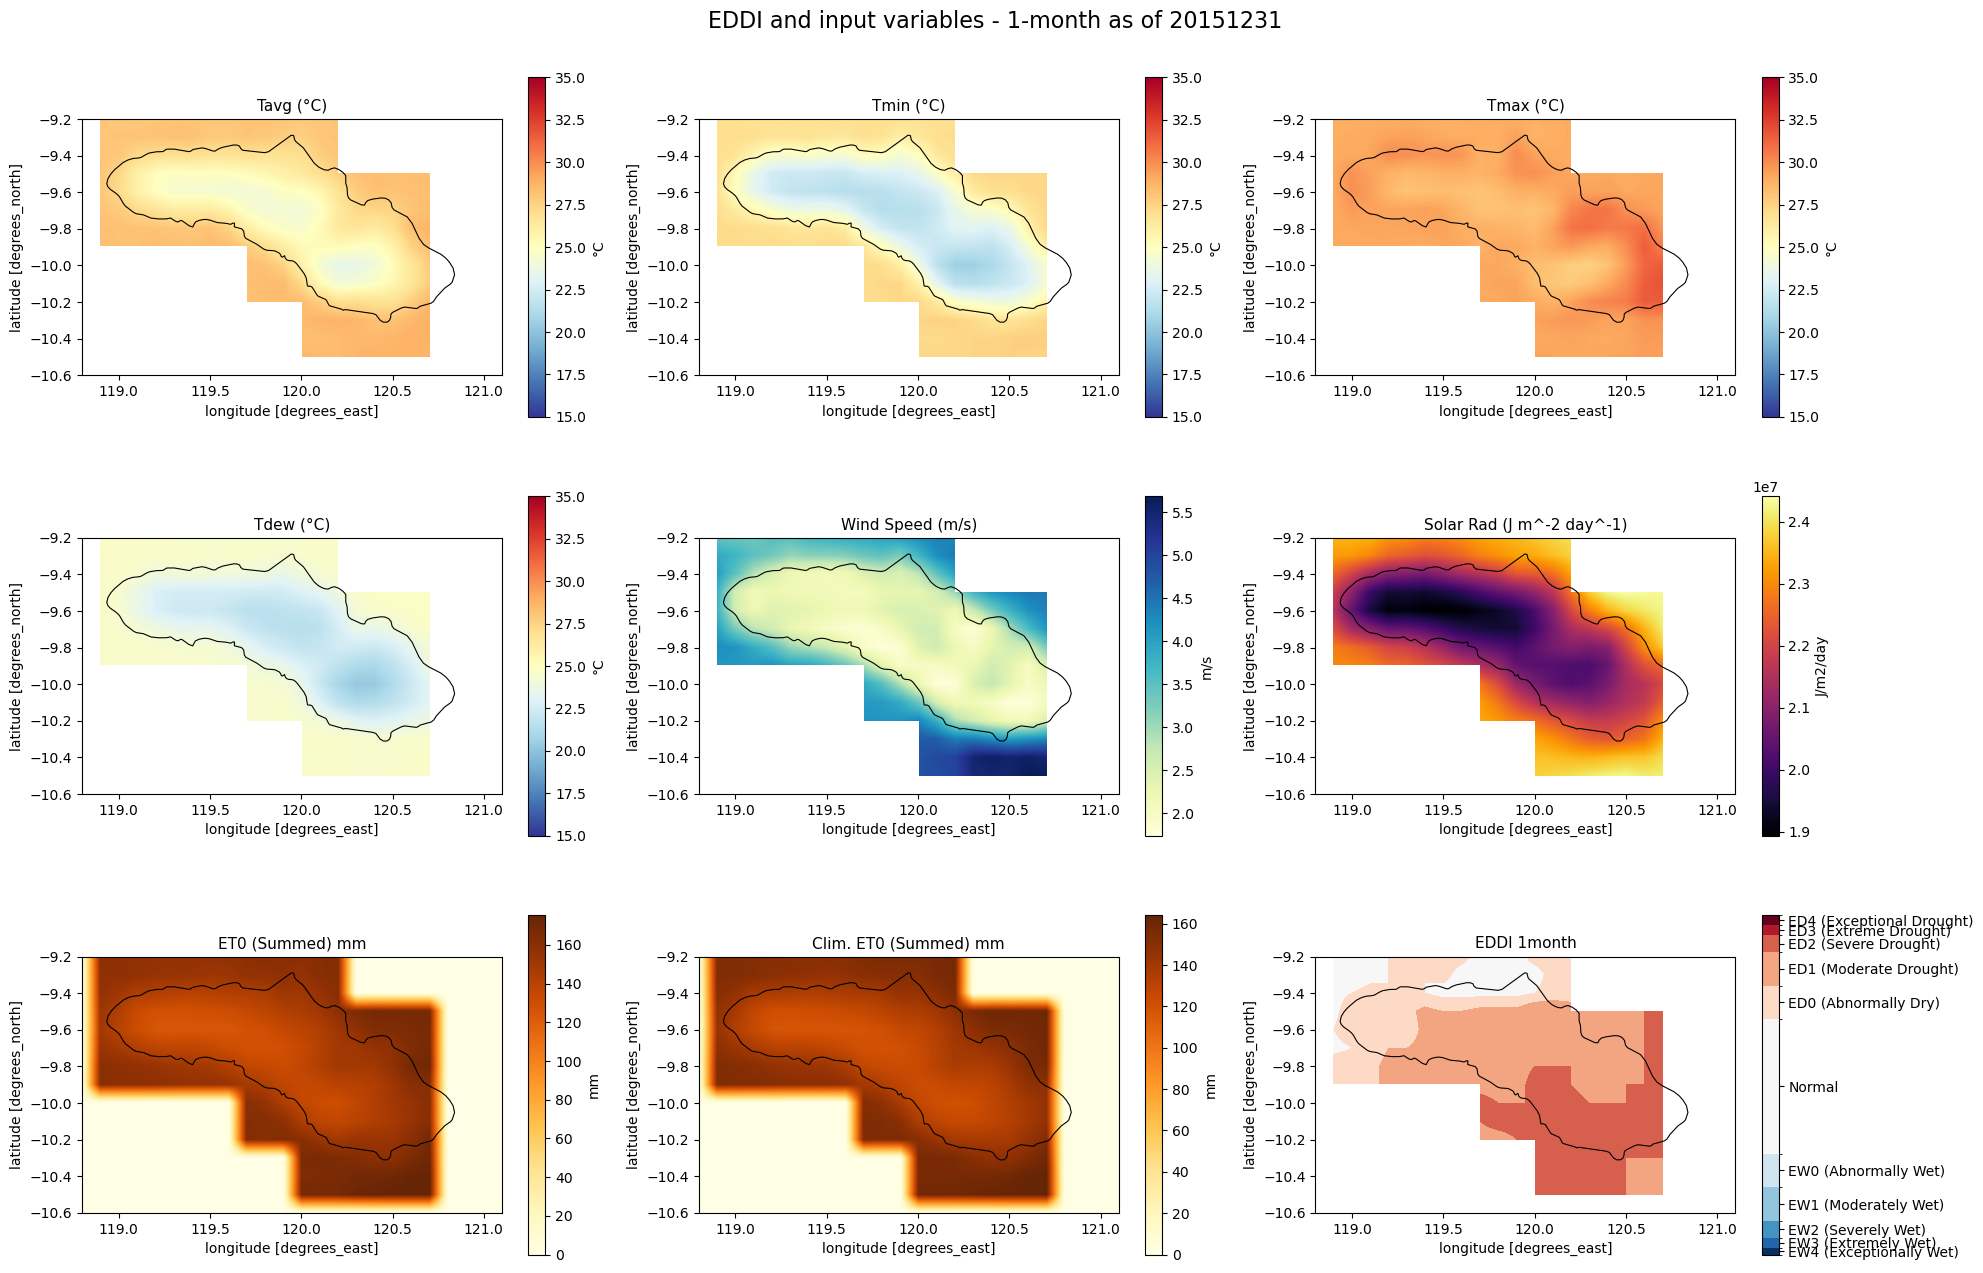

[INFO] Saving figure to /mnt/d/temp/eddi/images/idn_cli_agera5_eddi_2month_20151231.png


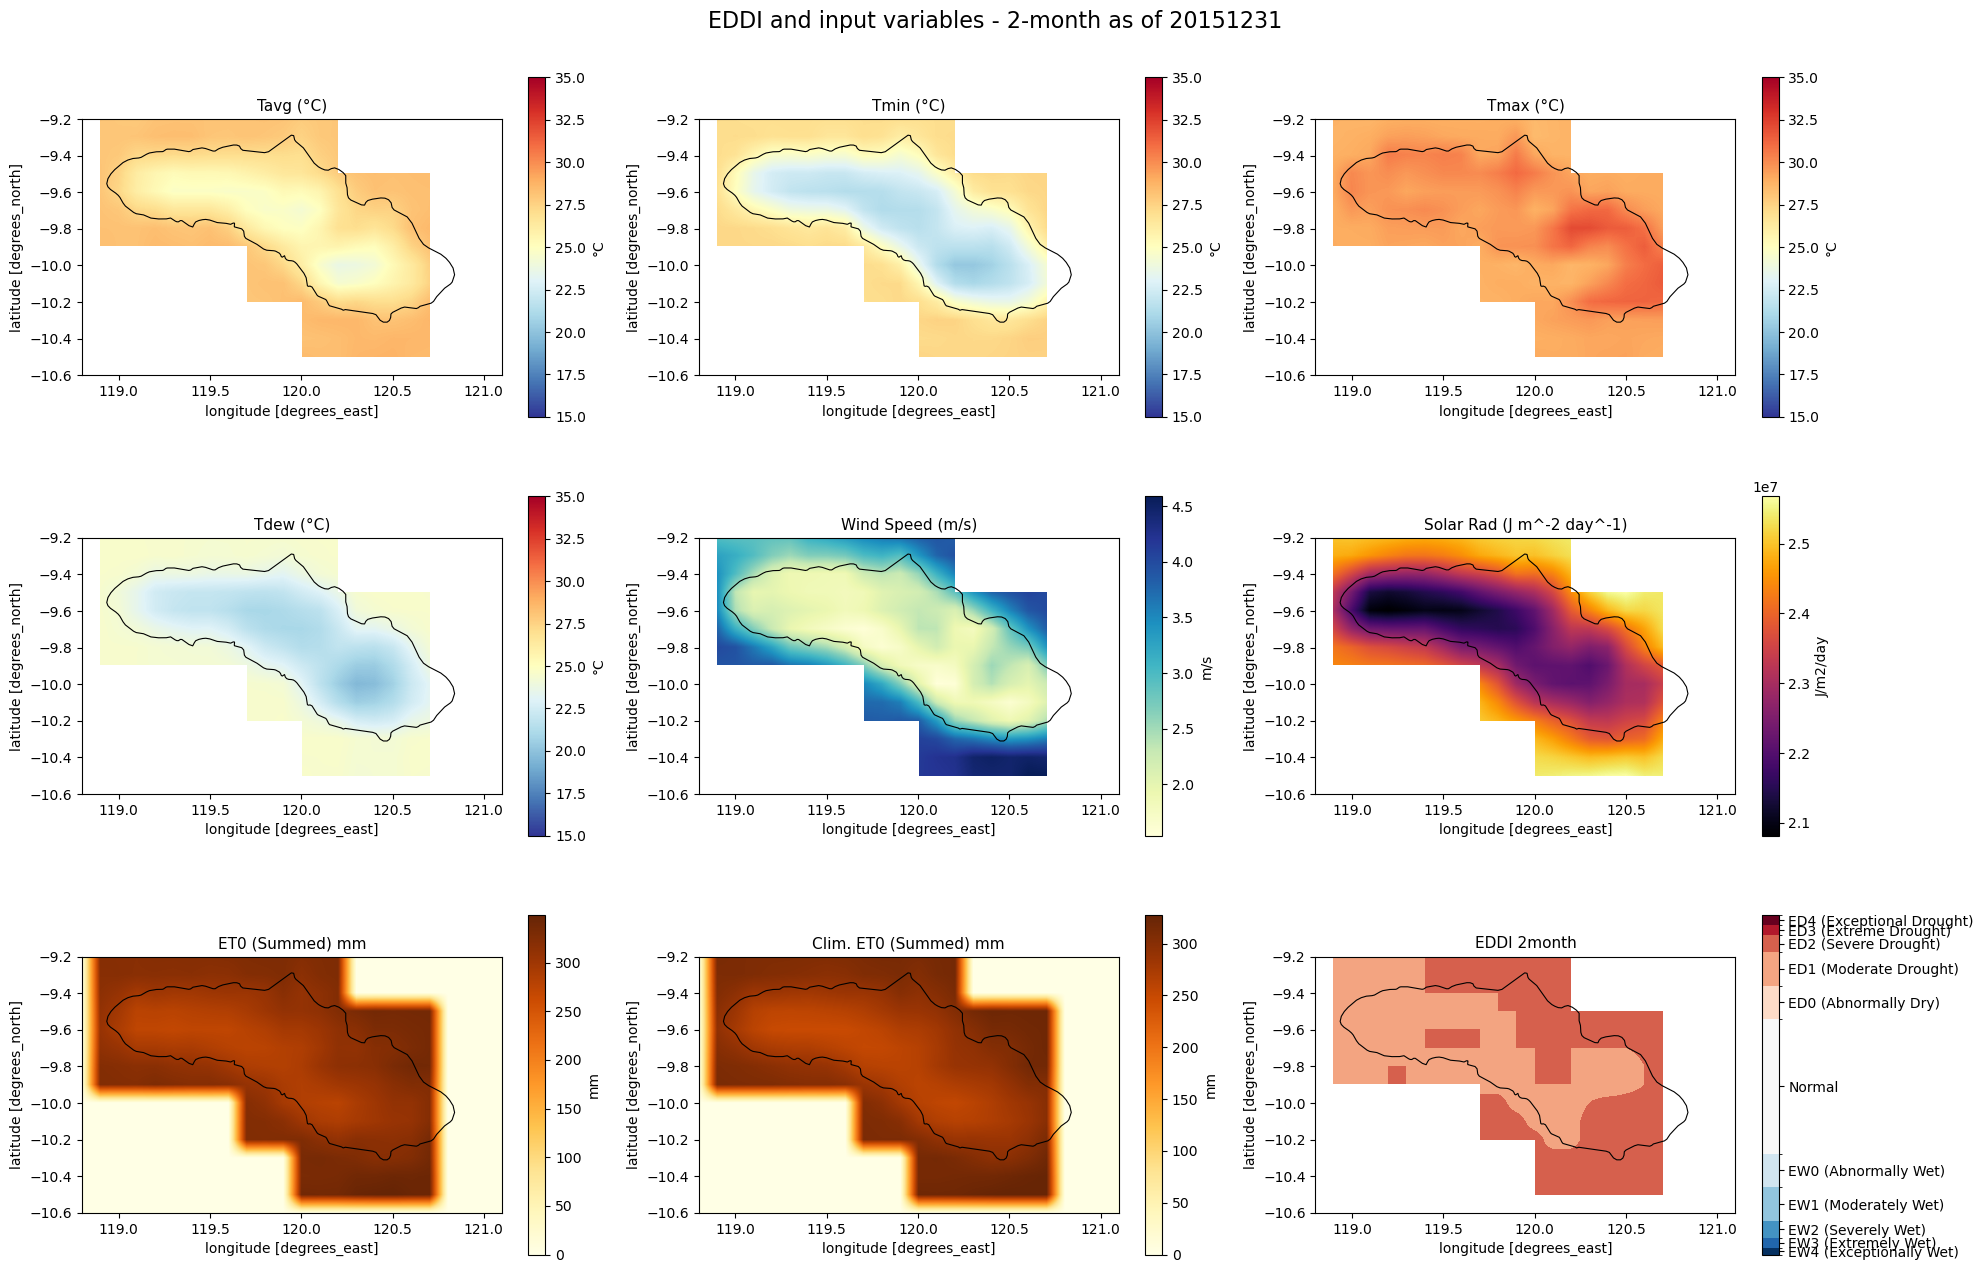

[INFO] Saving figure to /mnt/d/temp/eddi/images/idn_cli_agera5_eddi_3month_20151231.png


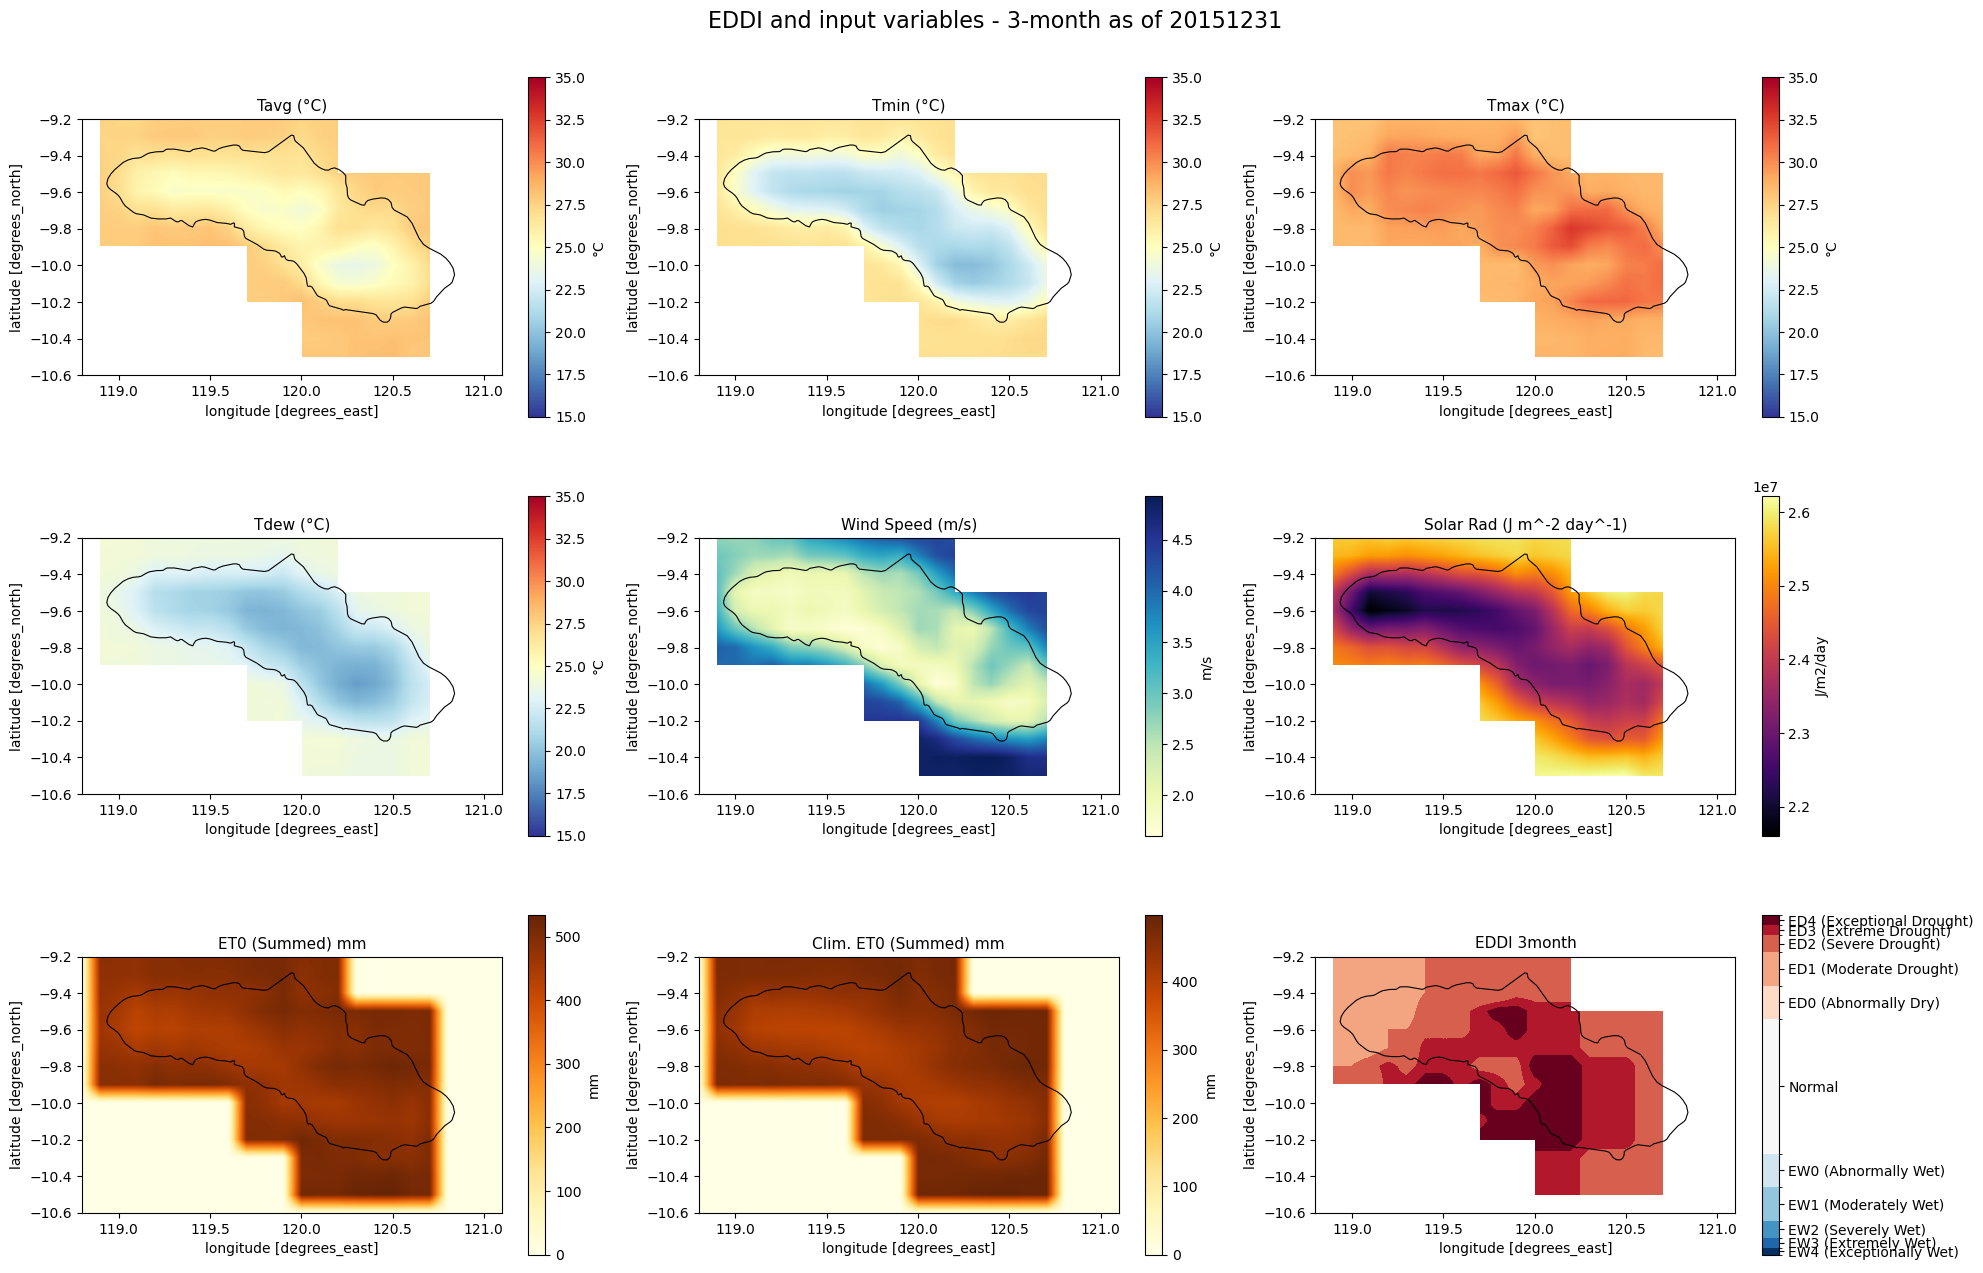

[INFO] Saving figure to /mnt/d/temp/eddi/images/idn_cli_agera5_eddi_6month_20151231.png


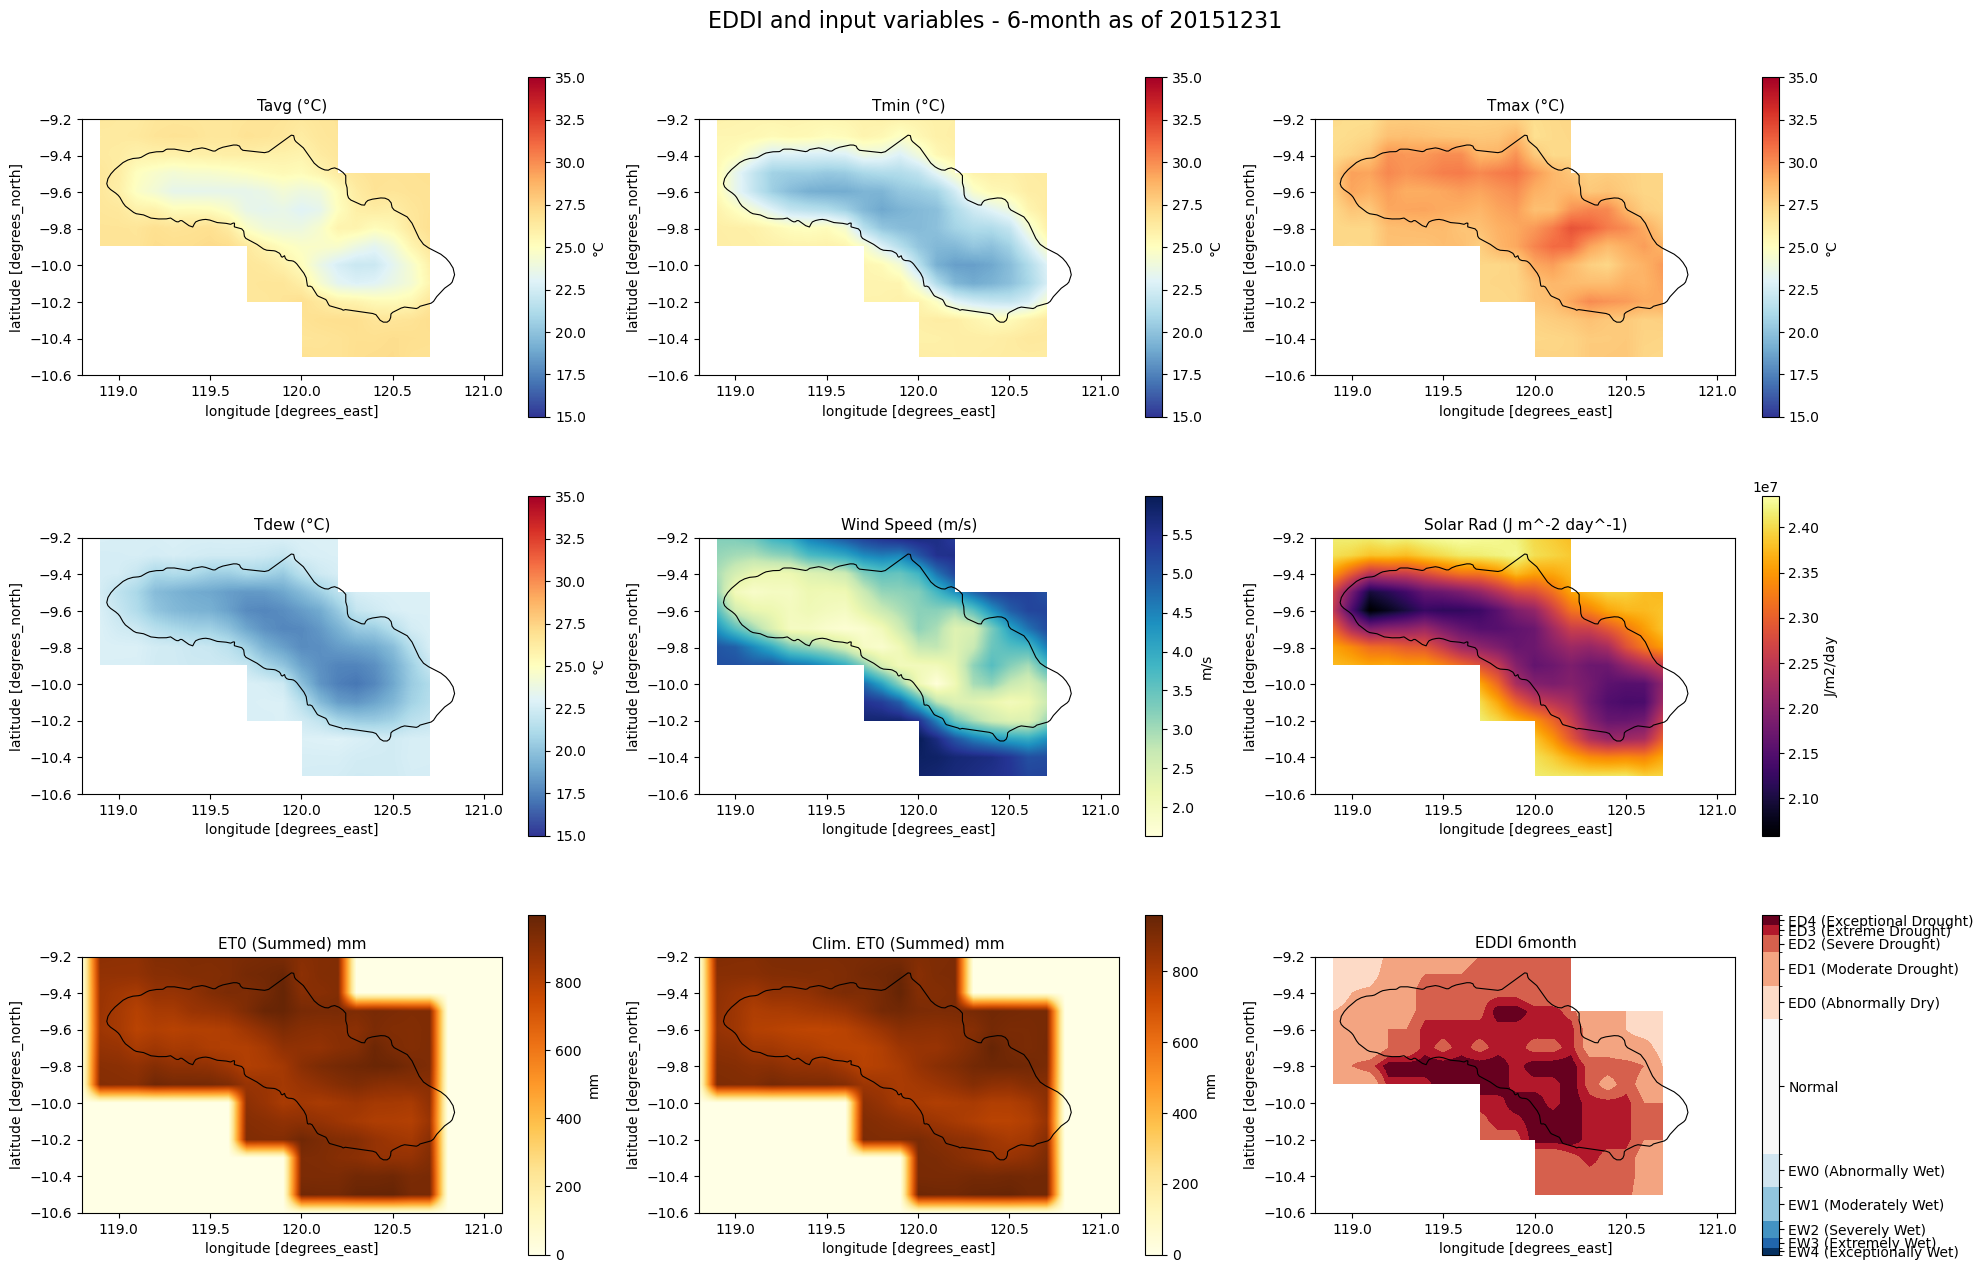

[INFO] Saving figure to /mnt/d/temp/eddi/images/idn_cli_agera5_eddi_9month_20151231.png


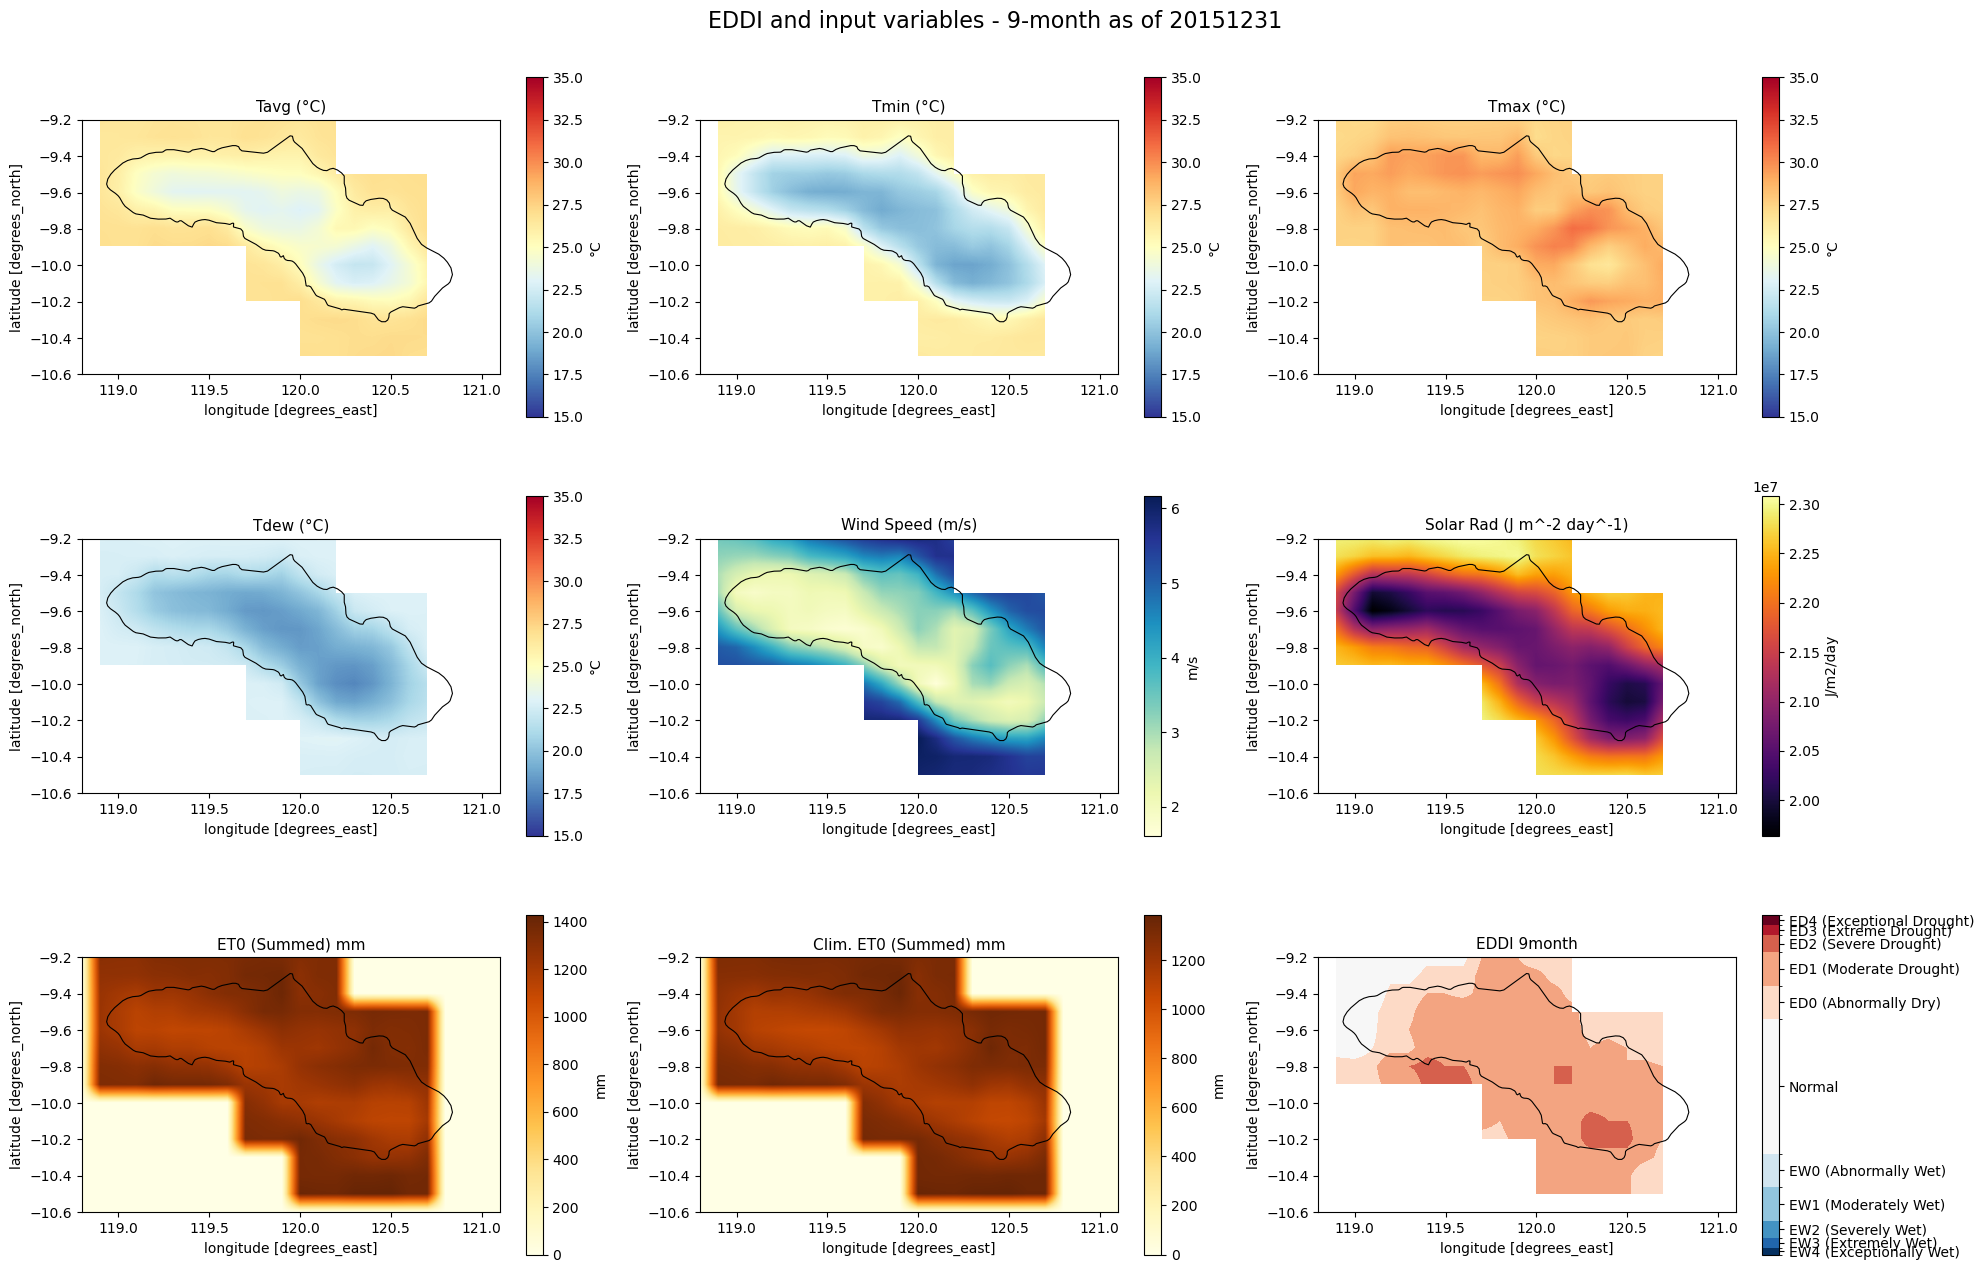

[INFO] Saving figure to /mnt/d/temp/eddi/images/idn_cli_agera5_eddi_12month_20151231.png


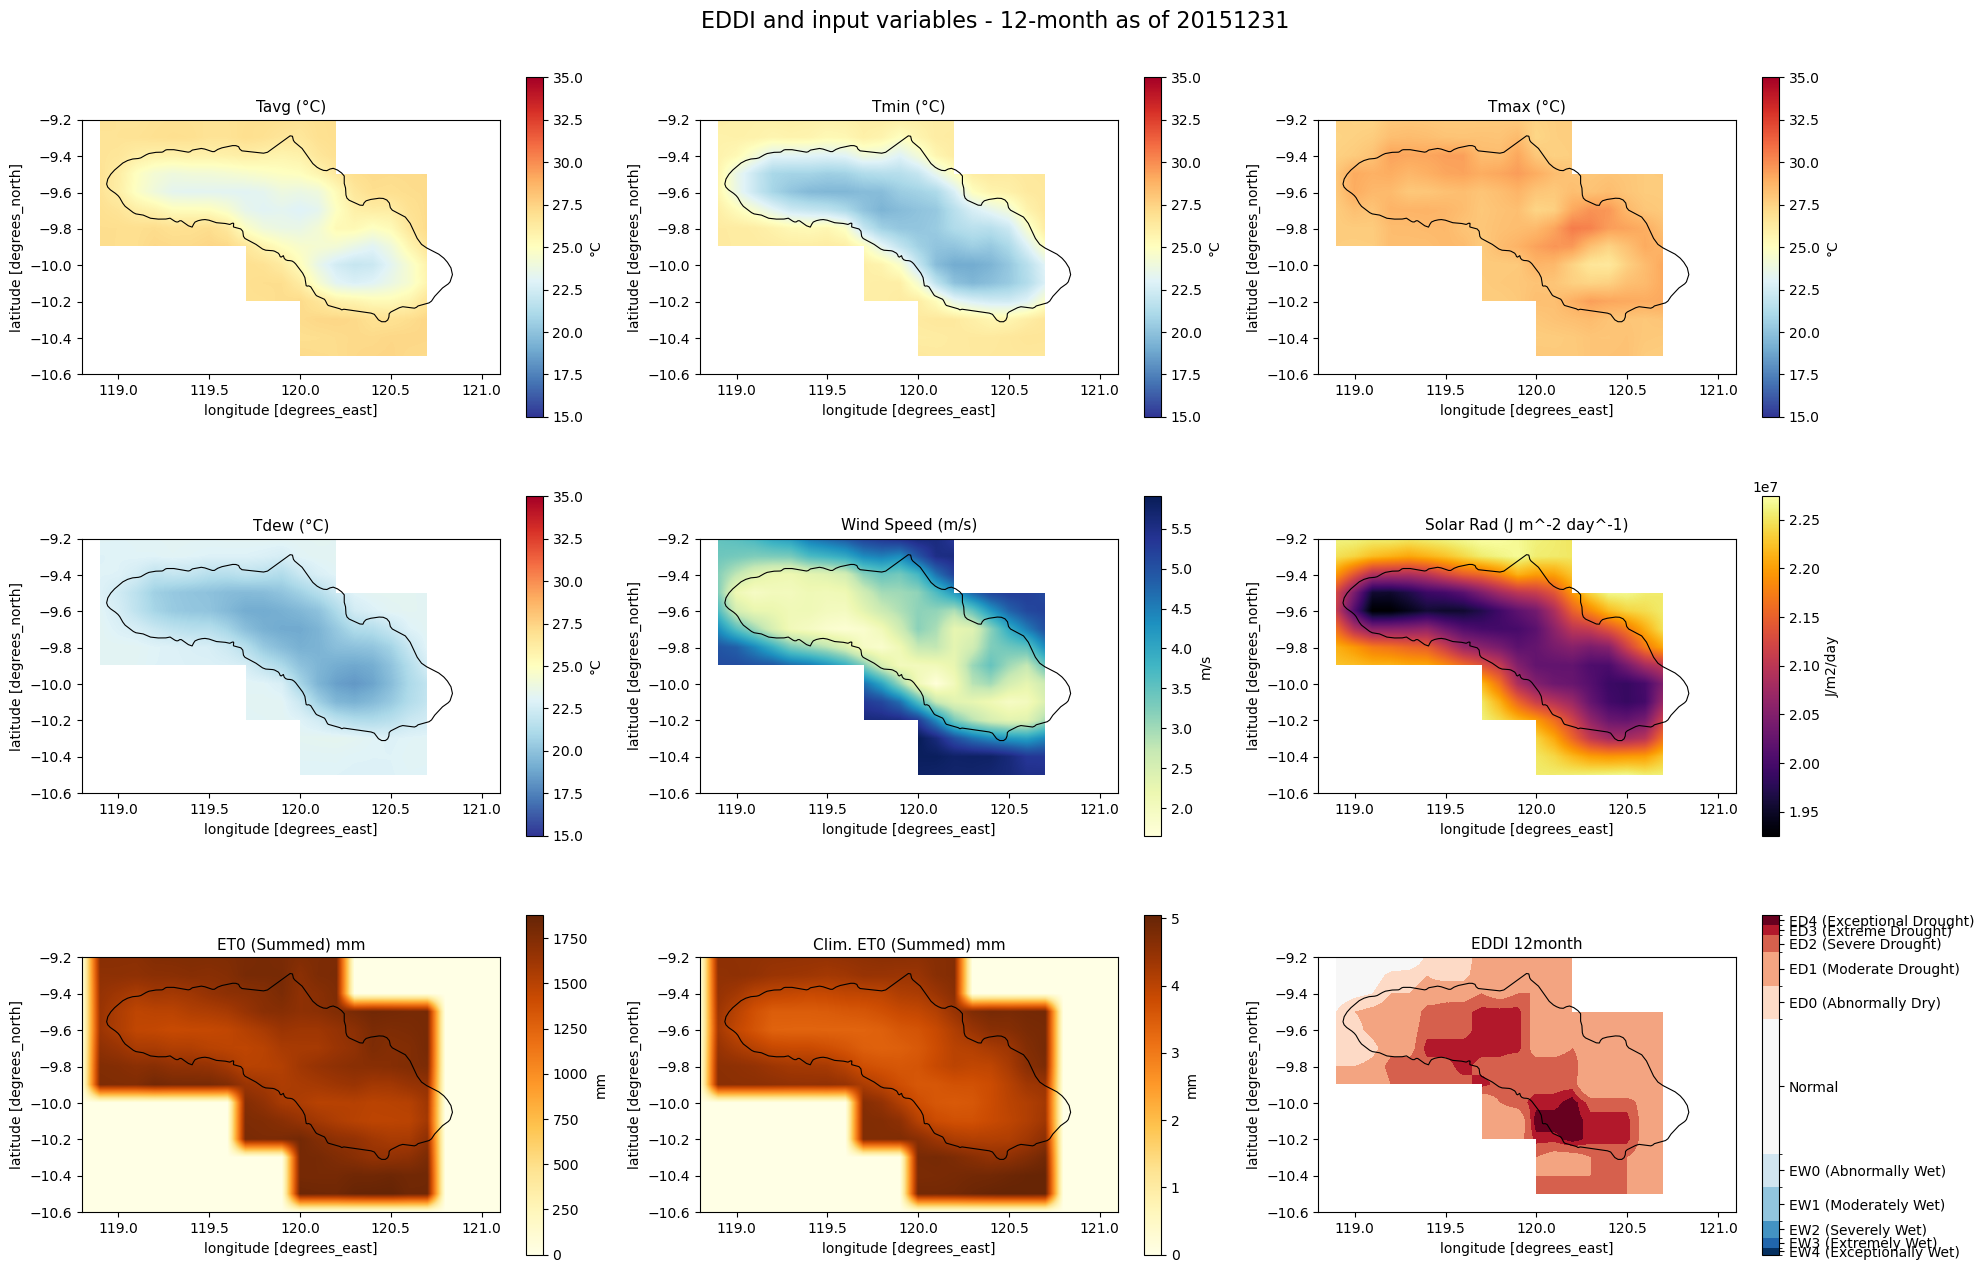

In [9]:
# Example usage
if __name__ == "__main__":
    # Set the main folder
    main_folder = '/mnt/d/temp/eddi'
    # Set the year month and dekad 
    year = 2015
    month = 12
    dekad = 3
    # EDDI computations for these scales:
    time_scales = [1,2,3,6,9,12]  # e.g. [3] for 3-month EDDI

    # Run EDDI
    ds_result = process_climate_data(main_folder, year, month, dekad, time_scales)
    print("[INFO] Final EDDI dataset:")
    print(ds_result)

    # The end date from the dekad
    user_start_date, user_end_date = get_dekad_dates(year, month, dekad)

    # 3) Load the merged full data & climatology
    ds_full_path = f"{main_folder}/temp/idn_cli_agera5_sumba_full_1981_2024.nc"
    ds_clim_path = f"{main_folder}/climatology/idn_cli_agera5_sumba_clim_1991_2020.nc"
    ds_full = xr.open_dataset(ds_full_path)
    ds_clim = xr.open_dataset(ds_clim_path)

    # For each scale, we do one plot
    for scale in time_scales:
        # Shift the start date to reflect 'scale' months
        this_start_date = shift_date_by_months(user_end_date, scale)

        # 5) Plot EDDI and inputs for this scale
        plot_eddi_and_inputs(
            ds_full=ds_full,
            ds_clim=ds_clim,
            ds_eddi=ds_result,
            scale=scale,
            user_start_date=this_start_date,
            user_end_date=user_end_date,
            main_folder=main_folder
        )
